In [383]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [560]:
#Reading in the data
data = np.load('../data/same_preset_MC_500_5_4.npz.npy')
trueCls = np.load('../data/same_preset_MC_500_5_4_reference_classes.npy')
data.shape

(500, 5, 4)

In [561]:
#Inferring the number of classes and data length
numData = data.shape[0]
numExperts = data.shape[1]
numClasses = data.shape[2]

In [562]:
def swap_class(z, row_idx, numClasses):
    """
    INPUT-
    z - class assignments for every data point(one-hot encoded)
    row_idx - row index for which the class is to be changed
    numClasses - number of classes.
    OUTPUT-
    new_z - class assignments for every data point after the swap
    """
    new_z = np.copy(z)
    classes = list(range(numClasses))
    old_class = np.where(z[row_idx,:] == 1)[0][0]
    #Removing the old class
    del classes[old_class]
    new_class = np.random.choice(classes)
    new_row = np.zeros(numClasses)
    new_row[new_class] = 1.
    new_z[row_idx] = new_row
    return new_z

Generate confusion matrix using the data and the class assignments

In [563]:
def gen_confusion_matrix(z, data):
    """
    INPUT
    z - class assignments for every data point(one-hot encoded)
    data - data used to infer the class distribution and assignments
    OUTPUT
    confMat - confusion matrix
    """
    numClasses = data.shape[2]
    numData = data.shape[0]
    confMat = 0.01*np.ones((numClasses, numClasses))
    for data_idx in range(numData):
        dat = data[data_idx]
        data_val = np.sum(dat, axis=0)
        observed_cls = z[data_idx,:]
        class_num = np.where(observed_cls == 1)[0][0]
        confMat[class_num,:] += data_val
    confMat = confMat/np.sum(confMat, axis=1)[:, np.newaxis]
    return confMat

Likelihood function for the Multiclass data case.

In [564]:
def mc_likelihood(value=data, z=z, confMat=confMat):
    """
    value - data
    z - observed classes
    confMat - confidence matrix
    """
    log_like = 0
    numData = data.shape[0]
    numExperts = data.shape[1]
    numClasses = data.shape[2]
    for data_idx in range(numData):
        dat = data[data_idx]
        observed_cls = z[data_idx]
        class_num = np.where(observed_cls == 1)[0][0]
        log_like += np.sum(np.multiply(observed_cls,np.sum(np.multiply(np.sum(dat, axis=0),\
                            np.log(confMat[class_num])))))
    return log_like

In [565]:
"""
#Randomly generating the z's
data_num = np.random.choice(range(numClasses), size=numData)
z = np.eye(numClasses)[data_num]
"""
inferred_labels = np.argmax(data.sum(axis=1), axis=1)
z = np.eye(numClasses)[inferred_labels]
confMat = gen_confusion_matrix(z, data)

Simulated annealing code where we try to maximize the likelihood.

In [566]:
def simulated_annealing_mc(z, confMat, data, starting_temp=1, reanneal=0.001, num_iterations=100):
    #Inferring the number of classes and data length
    numData = data.shape[0]
    numExperts = data.shape[1]
    numClasses = data.shape[2]
    numAccepts = 0
    temp = starting_temp
    likelihood_trace = []
    best_likelihood_trace = []
    temp_trace = []
    best_start = z
    best_conf = confMat
    best_lik = -np.inf
    for i in range(num_iterations):
        swap_idx = np.random.choice(range(numData), size=1, replace=False)[0]
        z_new = swap_class(z, swap_idx, numClasses)
        confMatNew = gen_confusion_matrix(z_new, data)
        new_lik = mc_likelihood(data, z_new, confMatNew)
        old_lik = mc_likelihood(data, z, confMat)
        u = np.random.uniform()
        prob = min([1, np.exp((new_lik - old_lik)/temp)])
        #print prob, u
        #Always accepting if the likelihood increases
        if new_lik > old_lik:
            z = z_new
            confMat = confMatNew
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z_new
                best_conf = confMat
            likelihood_trace.append(new_lik)
            numAccepts += 1
        #Accepting based on the probability if the error does not reduce
        elif prob >= u:
            z = z_new
            confMat = confMatNew
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z
                best_conf = confMat
            likelihood_trace.append(new_lik)
            numAccepts += 1
        else:
            likelihood_trace.append(old_lik)
        #Reducing temperature every 10th iteration
        if i%10 == 0:
            temp = temp*0.99
        if i%1000 == 0:
            print "#",
        #Reannealing if the temperature is too low
        if temp < reanneal:
            temp = 1
        temp_trace.append(temp)
        best_likelihood_trace.append(best_lik)
    return likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik, best_conf, numAccepts

In [567]:
likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik, best_conf, numAccepts =\
simulated_annealing_mc(z, confMat, data, num_iterations=10000)

# # # # # # # # # #


#### All Results for Simulated annealing for Multiclass data

#### Using Harder Datasets

#### For extrahard_MC_40_5_4.npz.npy

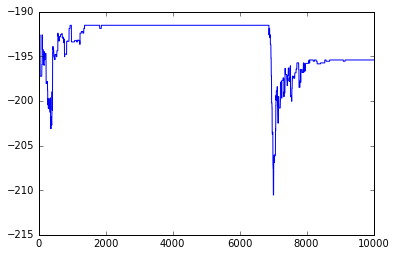

In [502]:
plt.plot(likelihood_trace)

In [503]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 87 %


In [504]:
best_conf

array([[ 0.7107016 ,  0.02242451,  0.06682948,  0.2000444 ],
       [ 0.18186773,  0.61791424,  0.12736192,  0.0728561 ],
       [ 0.044627  ,  0.044627  ,  0.75510657,  0.15563943],
       [ 0.09102471,  0.10919331,  0.21820494,  0.58157703]])

#### For extrahard_MC_80_5_4.npz.npy

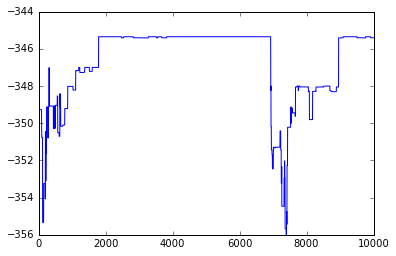

In [513]:
plt.plot(likelihood_trace)

In [514]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 85 %


In [515]:
best_conf

array([[ 0.77113078,  0.07153055,  0.07153055,  0.08580811],
       [ 0.14289794,  0.69506855,  0.13337776,  0.02865575],
       [ 0.10004998,  0.06672776,  0.74150283,  0.09171943],
       [ 0.09529703,  0.16193831,  0.03817593,  0.70458873]])

#### For extrahard_MC_100_5_4.npz.npy

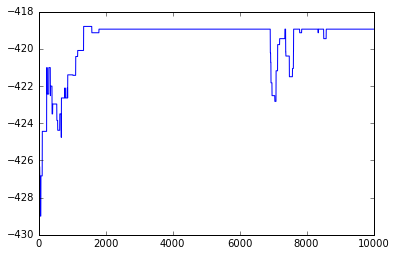

In [469]:
plt.plot(likelihood_trace)

In [470]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 95 %


In [471]:
best_conf

array([[ 0.77482506,  0.10004998,  0.10838054,  0.01674442],
       [ 0.06672097,  0.71837974,  0.08893661,  0.12596268],
       [ 0.00807742,  0.10404671,  0.74384197,  0.14403391],
       [ 0.1916861 ,  0.07505831,  0.0583972 ,  0.67485838]])

#### For extrahard_MC_200_5_4.npz.npy

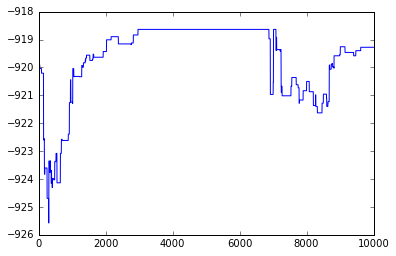

In [480]:
plt.plot(likelihood_trace)

In [481]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 88 %


In [482]:
best_conf

array([[ 0.69993334,  0.08150644,  0.09631906,  0.12224115],
       [ 0.11925088,  0.68839409,  0.08464082,  0.1077142 ],
       [ 0.10002069,  0.11036409,  0.70683354,  0.08278169],
       [ 0.094479  ,  0.07226172,  0.07781604,  0.75544323]])

#### For extrahard_MC_500_5_4.npz.npy

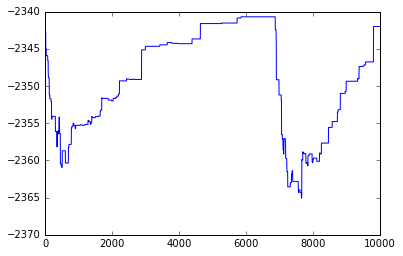

In [491]:
plt.plot(likelihood_trace)

In [492]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 93 %


In [493]:
best_conf

array([[ 0.71732447,  0.10910022,  0.09587796,  0.07769734],
       [ 0.09048632,  0.67933782,  0.12857914,  0.10159672],
       [ 0.10407453,  0.08131178,  0.70566142,  0.10895226],
       [ 0.11385453,  0.1061627 ,  0.08001046,  0.69997231]])

#### Using Preset Datasets

#### For same_preset_MC_40_5_4.npz.npy

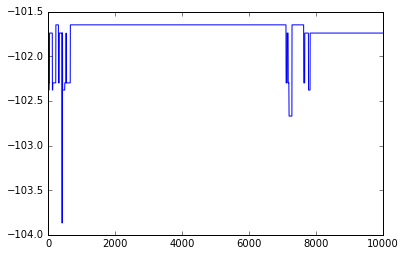

In [524]:
plt.plot(likelihood_trace)

In [525]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 97 %


In [526]:
best_conf

array([[  9.59432454e-01,   2.01838529e-02,   1.99840128e-04,
          2.01838529e-02],
       [  4.01678657e-02,   9.19464428e-01,   2.01838529e-02,
          2.01838529e-02],
       [  8.90319716e-02,   2.22024867e-04,   8.66119005e-01,
          4.46269982e-02],
       [  7.28561047e-02,   1.27361919e-01,   1.09193314e-01,
          6.90588663e-01]])

#### For same_preset_MC_80_5_4.npz.npy

In [536]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 97 %


In [537]:
best_conf

array([[  7.89784086e-01,   1.10055978e-01,   7.00719712e-02,
          3.00879648e-02],
       [  1.05218855e-04,   8.94465488e-01,   4.21927609e-02,
          6.32365320e-02],
       [  8.57768469e-02,   8.57768469e-02,   7.80750190e-01,
          4.76961158e-02],
       [  6.00759696e-02,   1.00959616e-02,   6.00759696e-02,
          8.69752099e-01]])

#### For same_preset_MC_100_5_4.npz.npy

In [548]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 100 %


In [549]:
best_conf

array([[ 0.83981126,  0.04806462,  0.03206974,  0.08005438],
       [ 0.0240723 ,  0.88779591,  0.04006718,  0.04806462],
       [ 0.04806462,  0.04006718,  0.90379079,  0.00807742],
       [ 0.03206974,  0.01607486,  0.04806462,  0.90379079]])

#### For same_preset_MC_200_5_4.npz.npy

In [558]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 100 %


In [559]:
best_conf

array([[ 0.86790114,  0.04403295,  0.04003359,  0.04803231],
       [ 0.04403295,  0.88389858,  0.03203487,  0.04003359],
       [ 0.02403615,  0.02803551,  0.90389538,  0.04403295],
       [ 0.04803231,  0.02403615,  0.03603423,  0.8918973 ]])

#### For same_preset_MC_500_5_4.npz.npy

In [568]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 99 %


In [569]:
best_conf

array([[ 0.85392991,  0.03652149,  0.07143991,  0.03810869],
       [ 0.03841354,  0.88955907,  0.03841354,  0.03361385],
       [ 0.03361385,  0.03201395,  0.90075835,  0.03361385],
       [ 0.0548513 ,  0.04033611,  0.03549771,  0.86931488]])

Use only if needed below this!

#### For preset_MC_100_5_4.npz.npy

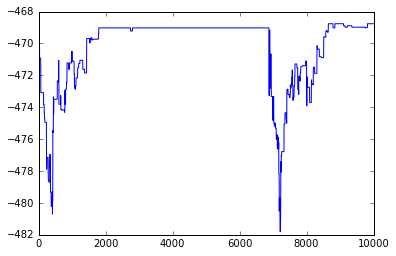

In [444]:
plt.plot(likelihood_trace)

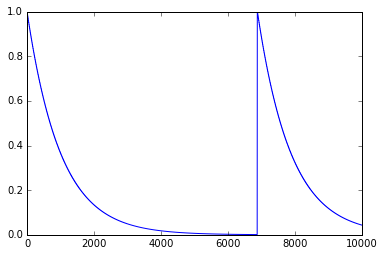

In [445]:
plt.plot(temp_trace)

In [446]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 91 %


In [447]:
best_conf

array([[ 0.62211197,  0.1407731 ,  0.1407731 ,  0.09634182],
       [ 0.05606206,  0.74384197,  0.10404671,  0.09604926],
       [ 0.06159643,  0.13849585,  0.63834205,  0.16156567],
       [ 0.09096692,  0.09096692,  0.0455289 ,  0.77253726]])

#### For same_preset_MC_500_5_4.npz.npy

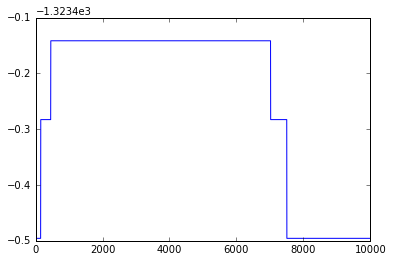

In [456]:
plt.plot(likelihood_trace)

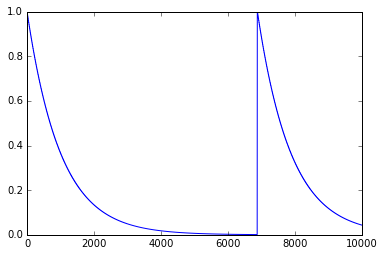

In [457]:
plt.plot(temp_trace)

In [458]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 99 %


In [459]:
best_conf

array([[ 0.87835978,  0.04801293,  0.04161334,  0.03201395],
       [ 0.04481313,  0.87356009,  0.04161334,  0.04001344],
       [ 0.0467873 ,  0.0484001 ,  0.86286369,  0.04194891],
       [ 0.04128309,  0.04128309,  0.0539807 ,  0.86345311]])

#### For same_preset_MC_200_5_4.npz.npy

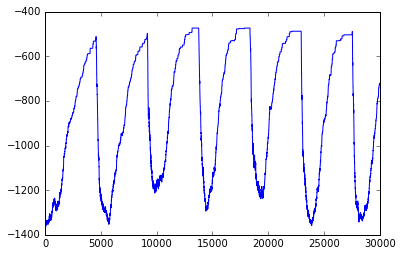

In [319]:
plt.plot(likelihood_trace)

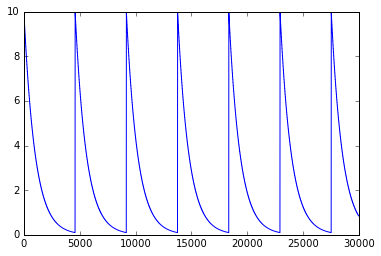

In [320]:
plt.plot(temp_trace)

In [321]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 100 %


In [322]:
best_conf

array([[ 0.86790114,  0.04403295,  0.04003359,  0.04803231],
       [ 0.04403295,  0.88389858,  0.03203487,  0.04003359],
       [ 0.02403615,  0.02803551,  0.90389538,  0.04403295],
       [ 0.04803231,  0.02403615,  0.03603423,  0.8918973 ]])